# Make Linear Regression Data

This notebook creates slightly noisy data that is amenable to being fit by a linear regression model.
The data arrives in a $100\times 2$ matrix $X$ along with a size-100 vector $y.$ The
data approximately fits the equation

$$y \approx Xw + b,$$

where $w,b\in\mathbb R^2.$

## Imports

In [1]:
%matplotlib inline

import math
import pickle

import matplotlib.pyplot as plt
import numpy as np

from mpl_toolkits.mplot3d               import Axes3D
from sklearn.datasets.samples_generator import make_blobs
from sklearn.linear_model               import LinearRegression, Ridge
from sklearn.model_selection            import train_test_split

## Parameters

In [2]:
n_pts = 100
x_dim = 2

## Create the data

In [3]:
# Choose a fixed random seed for numpy to keep
# things reproducible.

np.random.seed(12)

In [4]:
# Create some random x values with a tad of creativity.
# We could just sample x uniformly or normally, but it's
# more fun (and potentially more bug-revealing) to choose
# them in a more interesting fashion.

X, _ = make_blobs(n_samples=n_pts, n_features=x_dim, centers=3)
X.shape

(100, 2)

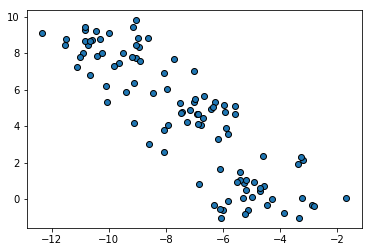

In [5]:
# Let's see what the first two coordinates look like.

plt.scatter(X[:, 0], X[:, 1], edgecolors='k')
plt.show()

In [6]:
# Choose w and b.

w = np.random.rand(x_dim, 1) * 5
b = np.random.rand(1) * 5

print('w:\n', w)
print('b:\n', b)

w:
 [[3.50714654]
 [4.52541479]]
b:
 [1.17899335]


In [7]:
# Set y = X * w + b + eps, where eps is some zero-centered noise.

y = X.dot(w) + b + np.random.randn(n_pts, 1)
y.shape

(100, 1)

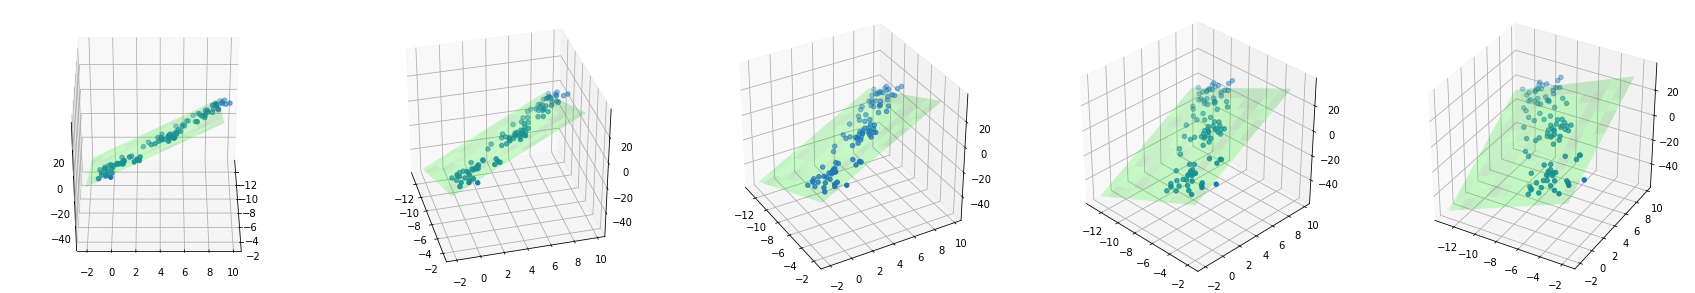

In [8]:
# Perform a visual check of the data.

def low(arr):
    return math.floor(np.min(arr))

def hi(arr):
    return math.ceil(np.max(arr))

def draw_pts(ax):
    xvals, yvals = X[:, 0], X[:, 1]
    x_rng = np.arange(low(xvals), hi(xvals))
    y_rng = np.arange(low(yvals), hi(yvals))
    xx, yy = np.meshgrid(x_rng, y_rng)
    zz = xx * w[0, 0] + yy * w[1, 0] + b
    ax.plot_surface(xx, yy, zz, color=(0, 1, 0, 0.2))
    ax.scatter(xvals, yvals, y)

fig = plt.figure(figsize=(30, 5))

n_figs = 5
for i in range(n_figs):
    ax = fig.add_subplot(1, n_figs, i + 1, projection='3d')
    draw_pts(ax)
    ax.view_init(35, -15 * i)

plt.show()

## Split and save the data

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

In [10]:
data = [X_train, X_test, y_train, y_test]

with open('lin_reg_data.pkl', 'wb') as f:
    pickle.dump(data, f)

## Check which parameters we might learn from the data

### First, train a non-regularized model.

In [11]:
lin_model = LinearRegression().fit(X_train, y_train)

print('Trained w:\n', lin_model.coef_)
print('Trained b:\n', lin_model.intercept_)

Trained w:
 [[3.43790257 4.46471022]]
Trained b:
 [0.91556267]


/Users/tylerneylon/work/tfkoans/tfkoans-env/lib/python3.6/site-packages/sklearn/linear_model/base.py:509: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  linalg.lstsq(X, y)


In [12]:
# Determine the mean squared error for that solution.
# This gives us a near-optimal value that we can use
# to verify that tensorflow approaches are working as we'd like.

w_ = lin_model.coef_
b_ = lin_model.intercept_

err = X_train.dot(w_.T) + b_ - y_train
np.average(err ** 2)

0.7041851987027441

### Now, train a regularized model.

Sci-kit learn's ridge regression model minimizes

$$||Xw+b-y||_2^2 + \alpha ||w||_2^2.$$

I would like to think in terms of _mean_ squared error, rather than the sum of squared errors,
so I'll send in $n\cdot\alpha$, where $n$ is the number of rows
in $X$ (the number of data points we have),
as this sets up a loss function equivalent to this:

$$\frac{1}{n}||Xw+b-y||_2^2 + \alpha ||w||_2^2. \qquad\qquad (*)$$

In [28]:
# Fit a regularized linear model.

alpha = 0.5
n = X_train.shape[0]

ridge_model = Ridge(alpha = n * alpha).fit(X_train, y_train)

print('Trained w:\n', ridge_model.coef_)
print('Trained b:\n', ridge_model.intercept_)

Trained w:
 [[2.08963237 3.49181083]]
Trained b:
 [-4.5642858]


In [29]:
# Determine the value of our loss function (*) on these weights.

w_ = ridge_model.coef_
b_ = ridge_model.intercept_

err = X_train.dot(w_.T) + b_ - y_train
np.average(err ** 2) + alpha * (np.sum(w_ ** 2))

12.091123198433323

---

In [14]:
w_ = ridge_model.coef_
b_ = ridge_model.intercept_

err = X_train.dot(w_.T) + b_ - y_train
np.average(err ** 2) + alpha * (np.sum(w_ ** 2 + b_ ** 2))
np.average(err ** 2) + alpha * (np.sum(w_ ** 2))

12.091123198433323

In [15]:
# Fit a regularized linear model.
# XXX
# Try different solvers.

alpha = 1000.0

# Adjust alpha in order to simulate equal importance of all
# data points.
alpha *= X_train.shape[0]

ridge_model = Ridge(alpha = alpha, max_iter=10000, solver='cholesky').fit(X_train, y_train)

w_ = ridge_model.coef_
b_ = ridge_model.intercept_

err = X_train.dot(w_.T) + b_ - y_train
loss_w_b = np.average(err ** 2) + alpha * (np.sum(w_ ** 2 + b_ ** 2))
loss_wo_b = np.average(err ** 2) + alpha * (np.sum(w_ ** 2))

print('Trained w:\n', ridge_model.coef_)
print('Trained b:\n', ridge_model.intercept_)
print('Loss with b:', loss_w_b)
print('Loss without b:', loss_wo_b)

Trained w:
 [[-0.01041258  0.02609851]]
Trained b:
 [-4.32949921]
Loss with b: 3374173.1198869054
Loss without b: 151.69935427743508


In [16]:
X_train.shape

(90, 2)

In [17]:
w_sk = w_
b_sk = b_

In [18]:
# Check apparent loss value with parameters learned by keras.

w_ = np.array([[-0.01030226], [ 0.025919  ]])
b_ = np.array([-4.3258724])

err = X_train.dot(w_) + b_ - y_train
loss_w_b = np.average(err ** 2) + alpha * (np.sum(w_ ** 2 + b_ ** 2))
loss_wo_b = np.average(err ** 2) + alpha * (np.sum(w_ ** 2))

print('Loss with b:', loss_w_b)
print('Loss without b:', loss_wo_b)

Loss with b: 3368521.628747243
Loss without b: 150.66495252678766


In [19]:
def loss_values(w, b):
    err = X_train.dot(w) + b - y_train
    loss_w_b = np.average(err ** 2) + alpha * (np.sum(w ** 2 + b ** 2))
    loss_wo_b = np.average(err ** 2) + alpha * (np.sum(w ** 2))
    
    return loss_w_b, loss_wo_b

In [20]:
def loss_values2(w, b):
    err = X_train.dot(w) + b - y_train
    loss_w_b = np.sum(err ** 2) + alpha * (np.sum(w ** 2 + b ** 2))
    loss_wo_b = np.sum(err ** 2) + alpha * (np.sum(w ** 2))
    
    return loss_w_b, loss_wo_b

In [21]:
loss_values2(w_sk.T, b_sk)

(3381350.033549358, 7328.613016730169)

In [22]:
loss_values2(np.zeros((2, 1)), np.array([0]))

(8940.346288213083, 8940.346288213083)

In [23]:
w_sk

array([[-0.01041258,  0.02609851]])

In [24]:
for _ in range(5):
    print(loss_values2(w_sk.T + np.random.randn(2, 1) * 0.005, b_sk))

(3381357.314253554, 7335.893720926269)
(3381353.096059634, 7331.675527005873)
(3381358.975007061, 7337.554474433276)
(3381356.617011381, 7335.196478753202)
(3381354.733246282, 7333.312713653623)


In [25]:
loss_values2(w_keras, b_keras)

NameError: name 'w_keras' is not defined

In [ ]:
loss_values(w_, b_)

In [ ]:
loss_values(w_ + np.random.randn(2, 1) * 0.01, b_)

In [ ]:
loss_values(w_ + np.random.randn(2, 1) * 0.01, b_)

In [ ]:
loss_values(w_ + np.random.randn(2, 1) * 0.01, b_)

In [ ]:
loss_values(w_ + np.random.randn(2, 1) * 0.01, b_)

In [ ]:
loss_values(w_ + np.random.randn(2, 1) * 0.01, b_)

In [ ]:
loss_values(w_ + np.random.randn(2, 1) * 0.01, b_)

In [ ]:
loss_values(w_ + np.random.randn(2, 1) * 0.01, b_)

In [ ]:
loss_values(w_, b_ + np.random.randn(1, 1) * 0.01)

In [ ]:
w_.shape

In [ ]:
w_keras = np.array([[-0.01030226], [0.025919]])

In [ ]:
b_keras = np.array([-4.3258724])

In [ ]:
loss_values(w_keras, b_keras)

In [ ]:
loss_values(w_, b_)

In [ ]:
w_

In [ ]:
w_keras

In [ ]:
loss_values(w_sk.T, b_sk)

In [ ]:
loss_values(np.zeros((2, 1)), np.array([0]))